In [99]:
%matplotlib inline

import os
import re
import pandas as pd
import numpy as np
import seaborn as sns
import scipy
import itertools
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import tree
from sklearn import svm
from sklearn.neighbors import NearestCentroid
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# Table of contents <a name="toc"></a>

1. [Introduction](#introduction)
2. [Data preparation](#data-preparation)
3. [Model comparison](#model-comparison)
4. [Final results](#final-results)
5. [Author](#author)

# Introduction <a name="introduction"></a>

(go back to [Table of contents](#toc))

This notebook presents an exemplary solution to the introductory competition on Kaggle: <a href="https://www.kaggle.com/c/titanic" target="blank">Titanic</a>. The aim of the competition is to predict the survivalibity of the passengers based on their travel information: ticket class, fare, name, age, sex, family members, cabin, embarkment location and assigned cabin. The learning data set contains 891 entries, however some of them are incomplete (e.g. age is missing in 20% of entries and cabin in 77%).

The data preprocessing procedure adopted in this analysis is as follows:
* drop features with too many missing values: cabin
* drop features with little influence on the result: ticket number
* extract person's title from the name
* guess missing values: age based on title, fare based on ticket class
* sum columns with family members (SiSp + Parch)
* convert all string/categorical variables to discrete numerical (for *scikit-learn* classifiers)

Original data set:

In [100]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Data preparation <a name="data-preparation"></a>

(go back to [Table of contents](#toc))

In [101]:
# Median age based on title
# =========================
full = train.append(test)

# Extract titles from names and assign numerical values
titles = set()
names = full['Name'].values
p = re.compile(r'[.,]')
for n in names:
    if '.' in n:
        s = p.split(n)
        s = [x.strip() + '.' for x in s]
        titles.add(s[1])

title_num = {t: n for t, n in zip(titles, range(len(titles)))}
        
def name_to_title(name):
    for t in titles:
        if t in name:
            return t
    return 'unknown'
        
full['Title'] = full['Name'].apply(name_to_title).astype('category')
title_vs_age = full.groupby('Title').median()['Age'].to_dict()
sorted_age = full.groupby('Title').median()['Age']

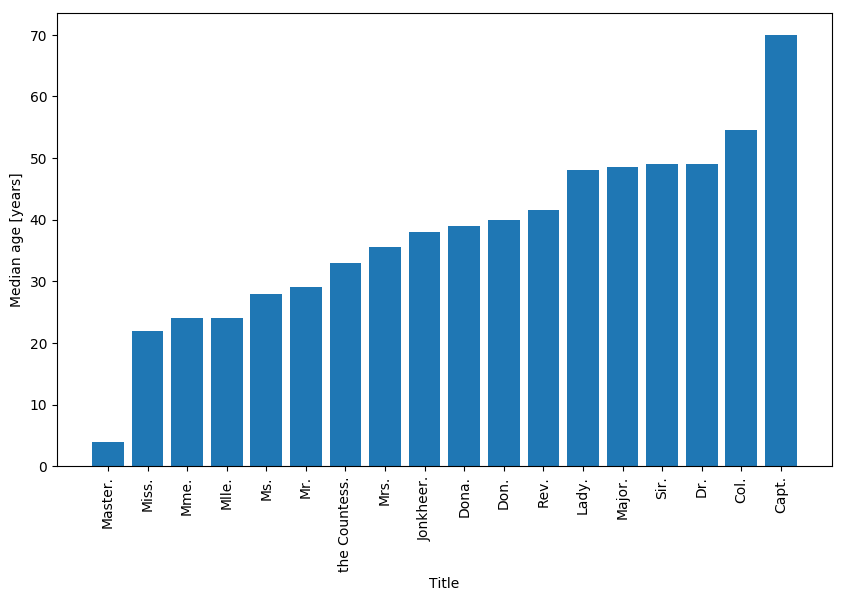

In [118]:
# Plot title vs. age
fig, ax = plt.subplots(1, 1, figsize=(10, 6), dpi=100)
sorted_age = sorted_age.sort_values()
ax.bar(np.arange(sorted_age.count()), [sorted_age[x] for x in sorted_age.index],
       tick_label=sorted_age.index.astype(list))
ax.set_ylabel('Median age [years]')
ax.set_xlabel('Title')
xticks = ax.get_xticklabels()
for lab in xticks:
    lab.set_rotation(90)

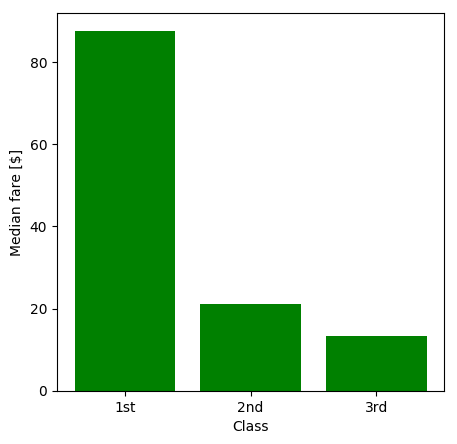

In [121]:
# Median fare based on Pclass
# ===========================
pclass_to_fare = full.groupby('Pclass').mean()['Fare'].to_dict()

# Plot median fare vs. ticket class
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=100)
ax.bar(np.arange(3), [pclass_to_fare[x] for x in [1, 2, 3]], tick_label=['1st', '2nd', '3rd'],
       color='green')
ax.set_xlabel('Class')
ax.set_ylabel('Median fare [$]');

In [104]:
# Prepare data for classifiers
# ============================
def preprocess(df):
    # Change sex to discrete numerical value (1 = male, 2 = female)
    df['Sex'] = df['Sex'].apply(lambda x: 1 if x == 'male' else 2)

    # Change embarkment location to discrete numerical (C = 1, Q = 2, S = 3, unkown = 0)
    mapping = {np.nan: 0, 'C': 1, 'Q': 2, 'S': 3}
    df['Embarked'] = df['Embarked'].apply(lambda x: mapping[x])

    # Change names to numeric values representing titles
    def name_to_title(name):
        for t in titles:
            if t in name:
                return t
        return 'unknown'

    df['Title'] = df['Name'].apply(name_to_title)
    df = df.drop('Name', axis=1)

    # Drop ticket column
    df = df.drop('Ticket', axis=1)
    
    # Drop cabin column (too many NaNs)
    df = df.drop('Cabin', axis=1)
    
    # Predict NaN in Age
    complete = df.dropna()
    incomplete = df[df.isnull().any(axis=1)]
    incomplete.loc[incomplete['Age'].isnull(), 'Age'] = incomplete['Title'].apply(lambda x: title_vs_age[x])
    
    # Predict NaN in Fare
    incomplete.loc[incomplete['Fare'].isnull(), 'Fare'] = incomplete['Pclass'].apply(lambda x: pclass_to_fare[x])
    
    # Merge
    df = complete.append(incomplete)
    
    # Create family column and delete SibSp and Parch
    df['Family'] = df['SibSp'] + df['Parch']
    df = df.drop(['SibSp', 'Parch'], axis=1)
    
    # Change title to number
    df['Title'] = df['Title'].apply(lambda x: title_num[x])
    
    return df

train = preprocess(train)
train.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,Title,Family
0,1,0,3,1,22.0,7.2500,3,11,1
1,2,1,1,2,38.0,71.2833,1,7,1
2,3,1,3,2,26.0,7.9250,3,0,0
3,4,1,1,2,35.0,53.1000,3,7,1
4,5,0,3,1,35.0,8.0500,3,11,0


# Model comparison <a name="model-comparison"></a>

(go back to [Table of contents](#toc))

## Decision Tree

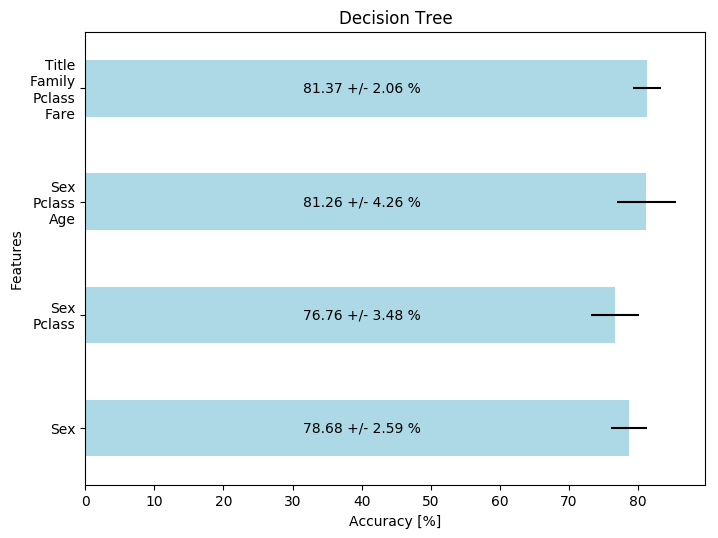

In [317]:
dt = pd.DataFrame(columns=['feat', 'acc'])

feat = [
    ['Sex'],
    ['Sex', 'Pclass'],
    ['Sex', 'Pclass', 'Age'],
    ['Title', 'Family', 'Pclass', 'Fare']
]

for f in feat:
    X = train[f]
    Y = train['Survived']
    clf = tree.DecisionTreeClassifier()
    scores = cross_val_score(clf, X, Y, cv=10, scoring='accuracy')
    dt = dt.append({'feat': str(f), 'acc': scores.mean(), 'std': scores.std()}, ignore_index=True)

# To percents
dt = dt.set_index('feat')
dt.index = map(lambda x: x.replace("', '", '\n').replace("['", '').replace("']", ''), dt.index)
dt['acc'] *= 100
dt['std'] *= 100

# Plot
ax = dt['acc'].plot.barh(figsize=(8, 6), xerr=dt['std'], color='lightblue')
fig = ax.get_figure()
fig.set_dpi(100)
ax.set_ylabel('Features')
ax.set_xlabel('Accuracy [%]')
ax.set_title('Decision Tree')

# Annotate
y = 0
x = 40.
for f in dt.index:
    ax.annotate('{:.2f} +/- {:.2f} %'.format(dt.loc[f, 'acc'], dt.loc[f, 'std']), xy=(x, y),
                va='center', ha='center')
    y += 1

## k-Nearest Neighbors

In [245]:
# Calculate scores
feat1 = ['Title', 'Family', 'Pclass', 'Fare']
feat2 = ['Sex', 'Pclass', 'Age']

X1 = train[feat1]
X2 = train[feat2]
Y = train['Survived']

knn1 = pd.DataFrame(columns=['k', 'weights', 'score_mean', 'score_std'])
knn2 = pd.DataFrame(columns=['k', 'weights', 'score_mean', 'score_std'])

k_list = np.arange(1, 41)
w_list = ['uniform', 'distance']

for k, w in itertools.product(k_list, w_list):
    clf = KNeighborsClassifier(k, weights=w)
    scores = cross_val_score(clf, X1, Y, cv=10, scoring='accuracy')
    knn1 = knn1.append({
        'k': k,
        'weights': w,
        'score_mean': scores.mean(),
        'score_std': scores.std()
    }, ignore_index=True)
    scores = cross_val_score(clf, X2, Y, cv=10, scoring='accuracy')
    knn2 = knn2.append({
        'k': k,
        'weights': w,
        'score_mean': scores.mean(),
        'score_std': scores.std()
    }, ignore_index=True)


knn1 = knn1.set_index(['k', 'weights'])
knn1['score_mean'] *= 100
knn1['score_std'] *= 100
knn2 = knn2.set_index(['k', 'weights'])
knn2['score_mean'] *= 100
knn2['score_std'] *= 100

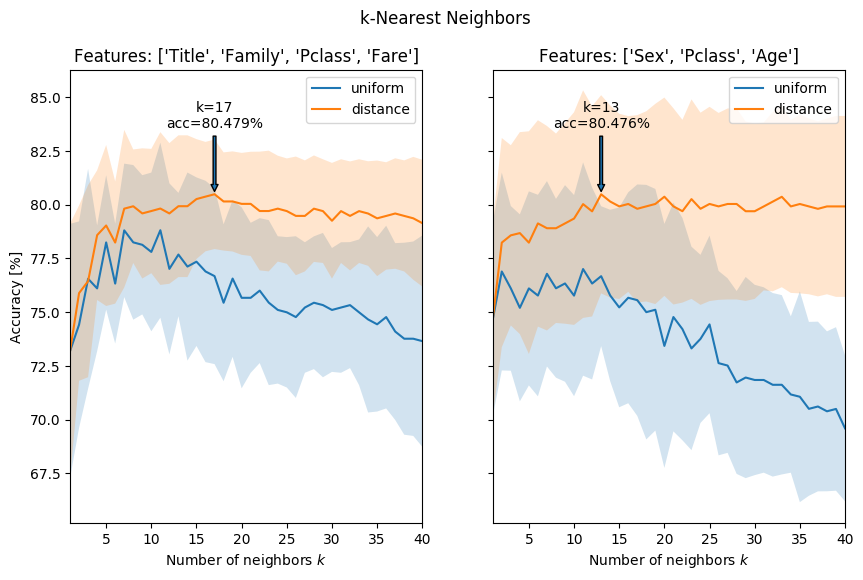

In [292]:
# Plot
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(10,6), dpi=100)

ax = axes[0]
ax.plot(knn1.xs('uniform', level='weights')['score_mean'], label='uniform')
ax.fill_between(knn1.xs('uniform', level='weights')['score_mean'].index, 
    knn1.xs('uniform', level='weights')['score_mean'] - knn1.xs('uniform', level='weights')['score_std'],
    knn1.xs('uniform', level='weights')['score_mean'] + knn1.xs('uniform', level='weights')['score_std'],
    alpha=0.2)
ax.plot(knn1.xs('distance', level='weights')['score_mean'], label='distance')
ax.fill_between(knn1.xs('distance', level='weights')['score_mean'].index, 
    knn1.xs('distance', level='weights')['score_mean'] - knn1.xs('distance', level='weights')['score_std'],
    knn1.xs('distance', level='weights')['score_mean'] + knn1.xs('distance', level='weights')['score_std'],
    alpha=0.2)
ax.set_xlim(1, 40)
ax.legend()
ax.set_ylabel('Accuracy [%]')
ax.set_xlabel('Number of neighbors $k$')
ax.set_title('Features: ' + str(feat1))

ax = axes[1]
ax.plot(knn2.xs('uniform', level='weights')['score_mean'], label='uniform')
ax.fill_between(knn2.xs('uniform', level='weights')['score_mean'].index, 
    knn2.xs('uniform', level='weights')['score_mean'] - knn2.xs('uniform', level='weights')['score_std'],
    knn2.xs('uniform', level='weights')['score_mean'] + knn2.xs('uniform', level='weights')['score_std'],
    alpha=0.2)
ax.plot(knn2.xs('distance', level='weights')['score_mean'], label='distance')
ax.fill_between(knn2.xs('distance', level='weights')['score_mean'].index, 
    knn2.xs('distance', level='weights')['score_mean'] - knn2.xs('distance', level='weights')['score_std'],
    knn2.xs('distance', level='weights')['score_mean'] + knn2.xs('distance', level='weights')['score_std'],
    alpha=0.2)
ax.set_xlim(1, 40)
ax.legend()
ax.set_xlabel('Number of neighbors $k$')
ax.set_title('Features: ' + str(feat2))

# Annotate best point
ax = axes[0]
dist1 = knn1.xs('distance', level='weights')['score_mean']
y_max = dist1.max()
x_max = dist1.loc[dist1 == y_max].index[0]
ax.annotate('k={}\nacc={:.3f}%'.format(x_max, y_max),
            xy=(x_max, y_max),
            xytext=(x_max, y_max + 3.1),
            arrowprops={'arrowstyle': 'simple'},
            horizontalalignment='center')

ax = axes[1]
dist2 = knn2.xs('distance', level='weights')['score_mean']
y_max = dist2.max()
x_max = dist2.loc[dist2 == y_max].index[0]
ax.annotate('k={}\nacc={:.3f}%'.format(x_max, y_max),
            xy=(x_max, y_max),
            xytext=(x_max, y_max + 3.1),
            arrowprops={'arrowstyle': 'simple'},
            horizontalalignment='center')
fig.suptitle('k-Nearest Neighbors')

## Support Vector Machine

In [108]:
print "SVM MODELS"
print "=========="

# SVM 1
feat = ['Sex']
X = train[feat]
Y = train['Survived']
clf = svm.SVC()

scores = cross_val_score(clf, X, Y, cv=10)
print 'Features: {}'.format(feat)
print 'Score: {:.3f} (+/-{:.3f})'.format(scores.mean(), scores.std())
print

# SVM 2
feat = ['Sex', 'Pclass']
X = train[feat]
Y = train['Survived']
clf = svm.SVC()

scores = cross_val_score(clf, X, Y, cv=10)
print 'Features: {}'.format(feat)
print 'Score: {:.3f} (+/-{:.3f})'.format(scores.mean(), scores.std())
print

# SVM 3
feat = ['Sex', 'Pclass', 'Age']
X = train[feat]
Y = train['Survived']
clf = svm.SVC(kernel='rbf')

scores = cross_val_score(clf, X, Y, cv=10)
print 'Features: {}'.format(feat)
print 'Score: {:.3f} (+/-{:.3f})'.format(scores.mean(), scores.std())
print

# SVM 4
feat = ['Title', 'Family', 'Pclass', 'Fare']
X = train[feat]
Y = train['Survived']
clf = svm.SVC(kernel='rbf')

scores = cross_val_score(clf, X, Y, cv=10)
print 'Features: {}'.format(feat)
print 'Score: {:.3f} (+/-{:.3f})'.format(scores.mean(), scores.std())
print

SVM MODELS
Features: ['Sex']
Score: 0.787 (+/-0.026)

Features: ['Sex', 'Pclass']
Score: 0.768 (+/-0.035)

Features: ['Sex', 'Pclass', 'Age']
Score: 0.795 (+/-0.031)

Features: ['Title', 'Family', 'Pclass', 'Fare']
Score: 0.800 (+/-0.039)



In [109]:
# Influence of C and gamma on SVM accuracy
# ========================================
feat = ['Title', 'Family', 'Pclass', 'Fare']
X = train[feat]
Y = train['Survived']

C_range     = [10**x for x in range(-4, 7, 1)]
gamma_range = [10**x for x in range(-4, 7, 1)]

grid_search = pd.DataFrame(columns=C_range, index=gamma_range)

# This code actually takes about an hour to complete...
#
# for C in C_range:
#     for gamma in gamma_range:
#         clf = svm.SVC(kernel='rbf', C=C, gamma=gamma)
#         scores = cross_val_score(clf, X, Y, cv=10)
#         grid_search.loc[gamma, C] = scores.mean()
# grid_search.to_csv('grid_search.csv')

# So just load the results from the previous run:
grid_search = pd.read_csv('grid_search.csv')
grid_search = grid_search.set_index('gamma')

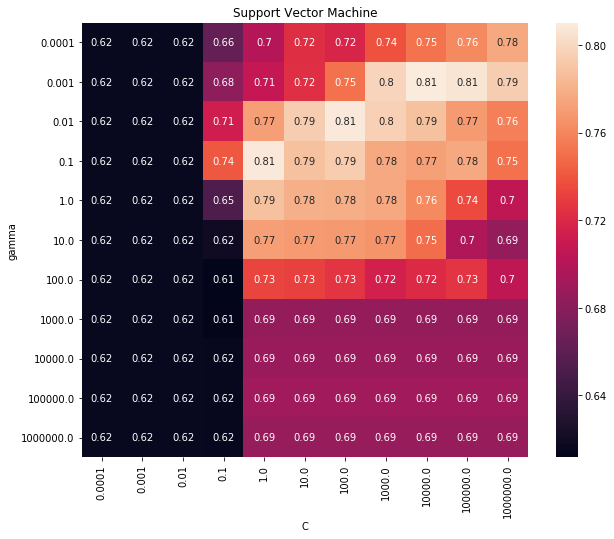

In [296]:
ax = sns.heatmap(grid_search, annot=True)
ax.set_xlabel('C')
fig = ax.get_figure()
fig.set_size_inches(10, 8)
ax.set_title('Support Vector Machine')

# Final results <a name="final-results"></a>

(go back to [Table of contents](#toc))

In [111]:
#clf = clf.fit(X, Y)
#train['Predict'] = clf.predict(X)

In [112]:
# Check on learning data
#check = train[['Survived', 'Predict']]
#train['OK'] = (train['Survived'] == train['Predict']).astype(int)
#ok = float(train['OK'].value_counts()[1])
#missed = float(train['OK'].value_counts()[0])
#
#print 'Percent misclassified: {:.2f}%'.format(100 * missed / (ok + missed))

In [113]:
# Test
#X = preprocess(test).drop(['PassengerId'], axis=1)
#test['Survived'] = clf.predict(X)
#test[['PassengerId', 'Survived']].to_csv('submission.csv', index=False)

# Author <a name="author"></a>

(go back to [Table of contents](#toc))

Krzysztof Arendt<br>
https://github.com/krzysztofarendt<br>
https://www.linkedin.com/in/krzysztofarendt/